In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import optimizer

# 使用预训练的ResNet50模型
model = models.resnet50(pretrained=True)

# 输入图像（batch_size, channels, height, width）
input_image = torch.randn(1, 3, 224, 224)
# print(input_image)

# 获取模型的最后一层全连接层的输出（特征向量）
with torch.no_grad():
    features = model(input_image)

print(features.shape)  # 输出: torch.Size([1, 1000])
# 在这个例子中，特征向量的长度是1000，因为ResNet50的最后一层有1000个输出单元，对应于1000个分类标签

In [ ]:
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 输出第一个特征图
        x = self.pool(F.relu(self.conv2(x)))  # 输出第二个特征图
        return x

model = SimpleCNN()
print(model)

# 输入图像（batch_size, channels, height, width）
input_image = torch.randn(1, 3, 32, 32)

# 获取卷积层输出的特征图
with torch.no_grad():
    feature_map = model(input_image)

print(feature_map.shape)  # 输出: torch.Size([1, 32, 8, 8])

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import init

class ExternalAttention(nn.Module):

    def __init__(self, d_model,S=64):
        super().__init__()
        self.mk=nn.Linear(d_model,S,bias=False)
        self.mv=nn.Linear(S,d_model,bias=False)
        self.softmax=nn.Softmax(dim=1)
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, queries):
        attn=self.mk(queries) #bs,n,S
        attn=self.softmax(attn) #bs,n,S
        attn=attn/torch.sum(attn,dim=2,keepdim=True) #bs,n,S
        out=self.mv(attn) #bs,n,d_model

        return out


if __name__ == '__main__':
    input=torch.randn(50,49,512)
    ea = ExternalAttention(d_model=512,S=8)
    output=ea(input)
    print(output.shape)



In [ ]:
from models.attention_modules.self_attention import AttentionModule
model = AttentionModule(feature_size=512,text_feature_size=512, num_heads=8)
print(model)

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer


In [ ]:
# 一个简单的RoBERTa模型
class SimpleRoBERTa(nn.Module):
    def __init__(self, pretrained_model_name='roberta-base'):
        super(SimpleRoBERTa, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask)
        return outputs


In [ ]:
# 定义一个用于文本编码的RoBERTaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


In [ ]:
# 现在，我们可以使用这个简单的RoBERTa模型来对文本进行编码了：
# 输入文本
text = "I love natural language processing!"

# 使用tokenizer将文本转换为模型所需的输入格式
input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')
attention_mask = torch.ones_like(input_ids)

# 实例化和加载模型
model = SimpleRoBERTa()
outputs = model(input_ids, attention_mask)

# 输出编码结果
print(outputs.size())


In [ ]:
import torch
from transformers import RobertaModel, RobertaTokenizer

# 加载 RoBERTa 模型和分词器
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 输入文本
text = "Hello, how are you?"

# 使用分词器对文本进行编码
inputs = tokenizer(text, return_tensors="pt")

# 传递输入到模型中进行推断
outputs = model(**inputs)

# 打印输出张量的形状
print("Last hidden state shape:", outputs.last_hidden_state.shape)
print("Pooler output shape:", outputs.pooler_output.shape)


In [ ]:
from torchvision.models import resnet18, resnet50
model = resnet50(pretrained=True)
print(model)

In [ ]:
import torch
from torch import nn

class eca_layer(nn.Module):
    """Constructs a ECA module.

    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)
        

In [ ]:
from models.attention_modules.self_attention import AttentionModule, SelfAttentionMap, GlobalCrossAttentionMap
model = AttentionModule(512,512,2)
print(model)

In [ ]:
compositor_object1=1
compositor_object2=13

text_encoder_object=2
lower_img_encoder_object=2
upper_img_encoder_object=2

compositors = {
    'compositor1': compositor_object1,
    'compositor2': compositor_object2,
}

models = {
    'text_encoder': text_encoder_object,
    'lower_image_encoder': lower_img_encoder_object,
    'upper_image_encoder': upper_img_encoder_object,
}
models

In [ ]:
models.update(compositors)
print(models)

In [ ]:
from models.compositors.global_style_models import GlobalStyleTransformer2
from models.compositors.transformers import DisentangledTransformer


def global_styler_factory(code, feature_size, text_feature_size):
    if code == GlobalStyleTransformer2.code():
        return GlobalStyleTransformer2(feature_size, text_feature_size)
    else:
        raise ValueError("{} not exists".format(code))


def transformer_factory(feature_sizes, configs):
    text_feature_size = feature_sizes['text_feature_size']
    num_heads = configs['num_heads']

    global_styler_code = configs['global_styler']
    global_styler = global_styler_factory(global_styler_code, feature_sizes['layer4'], text_feature_size)
    return {'layer4': DisentangledTransformer(feature_sizes['layer4'], text_feature_size, num_heads=num_heads,
                                              global_styler=global_styler)}


In [3]:
from models.compositors import transformer_factory
from models.image_encoders import image_encoder_factory
from models.text_encoders import text_encoder_factory
from language import vocabulary_factory
from data.shoes import ShoesDataset
DEFAULT_VOCAB_PATHS = {
    **dict.fromkeys(ShoesDataset.all_codes(), ShoesDataset.vocab_path()),
}
DEFAULT_VOCAB_PATHS

{'shoes': './data/shoes/shoes_vocab.pkl'}

In [21]:
configs = {
    'alpha_scale': 1,
    'augmenter': 'normal_gaussian',
    'batch_size': 24,
    'beta_scale': 1,
    'checkpoint_path': './ckpt',
    'compositor': 'transformer',
    'config_path': 'configs/shoes_config.json',
    'dataset': 'shoes',
    'decay_step': 35,
    'decay_step_second': 42,
    'device_idx': '0',
    'epoch': 1,
    'evaluator': 'simple',
    'experiment_description': 'bert',
    'experiment_dir': 'experiments',
    'export_root': 'experiments\\bert_2024-07-06_0',
    'feature_size': 512,
    'gamma': 0.1,
    'gamma_scale': 1,
    'global_styler': 'global2',
    'heads': 12,
    'image_encoder': 'resnet50_layer4',
    'img_size': 224,
    'layers': 12,
    'lr': 0.0001,
    'lr_scheduler': 'MultiStepWithWarmup',
    'lstm_hidden_size': 512,
    'margin': 12,
    'metric_loss': 'batch_based_aleatoric_loss',
    'momentum': 0.9,
    'norm_scale': 4,
    'num_gpu': 1,
    'num_heads': 8,
    'num_workers': 0,
    'optimizer': 'RAdam',
    'output_dim': 512,
    'patch_size': 16,
    'random_seed': 13877,
    'selector': 'all',
    'shuffle': True,
    'stride': True,
    'stride_size': 16,
    'text_encoder': 'roberta',
    'text_feature_size': 512,
    'topk': '1,5,10,50',
    'trainer': 'tirg',
    'use_transform': True,
    'vocab_path': '../data/shoes/shoes_vocab.pkl',
    'vocab_threshold': 0,
    'wandb_account_name': 'yubin06',
    'wandb_project_name': 'UR',
    'warmup_iters': 5,
    'weight_decay': 5e-05,
    'width': 768,
    'word_embedding_size': 512
}
vocabulary = vocabulary_factory(config={
    'vocab_path': configs['vocab_path'] if configs['vocab_path'] else DEFAULT_VOCAB_PATHS[configs['dataset']],
    'vocab_threshold': configs['vocab_threshold']
})
print(vocabulary)

In [22]:
text_encoder, text_fc = text_encoder_factory(vocabulary, config=configs)
lower_img_encoder, upper_img_encoder = image_encoder_factory(config=configs)
layer_shapes = lower_img_encoder.layer_shapes()
compositors = transformer_factory({'layer4': layer_shapes['layer4'],
                                       'image_feature_size': upper_img_encoder.feature_size,
                                       'text_feature_size': text_encoder.feature_size}, configs=configs)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
print(compositors)

{'layer4': DisentangledTransformer(
  (att_module): AttentionModule(
    (gam_attention): GAM_Attention(
      (channel_attention): Sequential(
        (0): Linear(in_features=2048, out_features=512, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=512, out_features=2048, bias=True)
      )
      (spatial_attention): Sequential(
        (0): Conv2d(2048, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 2048, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (self_att_generator): SelfAttentionMap(
      (W_k): Conv2d(2048, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (W_q): Conv2d(2048, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (softmax): Softmax(dim=2)
    )
    

# EMMA

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from einops import rearrange
import numbers

## 维度转换

In [16]:
def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')
def to_4d(x, h, w):
    return rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

## 无偏置的层归一化

In [17]:
class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma + 1e-5) * self.weight

### 使用

In [24]:
# 定义一个简单的卷积神经网络
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.norm1 = BiasFree_LayerNorm(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 16 * 16, 10)  # 假设输出10类

    def forward(self, x):
        x = self.conv1(x)
        batch_size, channels, height, width = x.shape
        x = to_3d(x)
        x = self.norm1(x)
        x = to_4d(x, height, width)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(batch_size, -1)  # 展平张量
        x = self.fc(x)
        return x

In [25]:
model = SimpleCNN()
inputs = torch.randn(1, 3, 32, 32)
outputs = model(inputs)
print(outputs.shape)
# print(model)

torch.Size([1, 10])


In [26]:
# 测试代码
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()

# 输入图像张量，形状为 [batch_size, channels, height, width]
inputs = torch.randn(1, 3, 32, 32)
# 目标标签，形状为 [batch_size]
labels = torch.tensor([3])  # 示例目标标签

# 前向传播
outputs = model(inputs)

# 计算损失
loss = criterion(outputs, labels)

# 打印损失
print(f'Loss: {loss.item()}')

Loss: 2.4427390098571777


## 有偏置的层归一化

In [3]:
class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma + 1e-5) * self.weight + self.bias

## 层归一化

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type == 'BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

## 注意力模块

In [17]:
class AttentionBase(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super(AttentionBase, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.qkv1 = nn.Conv2d(3, dim, kernel_size=1, bias=qkv_bias)  # 将输入通道数从3转换为dim
        self.qkv2 = nn.Conv2d(dim, dim * 3, kernel_size=1, bias=qkv_bias)
        self.qkv3 = nn.Conv2d(dim * 3, dim * 3, kernel_size=3, padding=1, bias=qkv_bias)
        self.proj = nn.Conv2d(dim, dim, kernel_size=1, bias=qkv_bias)

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.qkv1(x)  # 先将通道数转换为dim
        qkv = self.qkv3(self.qkv2(x))
        q, k, v = qkv.chunk(3, dim=1)
        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v)
        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)
        out = self.proj(out)
        return out,attn


### 使用

In [18]:
from PIL import Image
from torchvision import transforms
image_path = '../image/2.jpg'  # 替换为你的图片路径
image = Image.open(image_path).convert('RGB')
# 定义预处理步骤
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整大小为32x32
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 标准化
])
# 应用预处理
input_tensor = preprocess(image).unsqueeze(0)  # 添加批次维度

# 定义注意力模块
attention_layer = AttentionBase(dim=64, num_heads=8)

# 应用注意力模块
output, attn_weights = attention_layer(input_tensor)


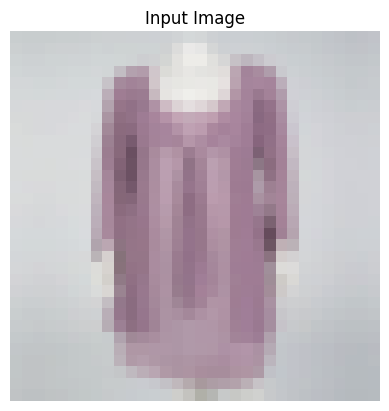

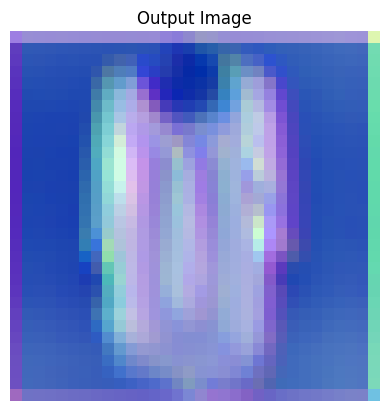

In [25]:
import matplotlib.pyplot as plt

def visualize_tensor(tensor, title):
    # 将张量转换为NumPy数组
    np_img = tensor.squeeze().detach().cpu().numpy()
    
    # 转换为适合Matplotlib显示的格式
    np_img = np.transpose(np_img, (1, 2, 0))
    
    # 取消标准化
    np_img = np_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    np_img = np.clip(np_img, 0, 1)

    # 绘制图像
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 可视化输入图像
visualize_tensor(input_tensor[0], title='Input Image')

# 将输出张量转换为适合可视化的格式
output_for_visualization = output.detach().cpu().squeeze(0)

# 选择前3个通道进行可视化
output_for_visualization = output_for_visualization[:3, :, :]

# 取消标准化
output_for_visualization = output_for_visualization.permute(1, 2, 0)  # 调整维度顺序
output_for_visualization = (output_for_visualization - output_for_visualization.min()) / (output_for_visualization.max() - output_for_visualization.min())

# 可视化输出图像
plt.imshow(output_for_visualization)
plt.title('Output Image')
plt.axis('off')
plt.show()


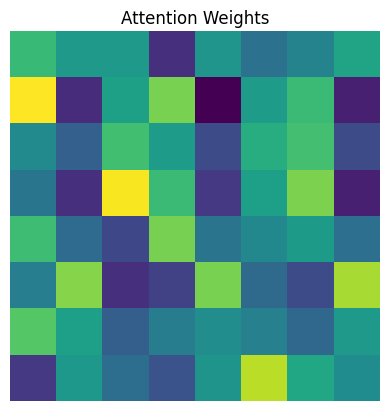

In [27]:
def visualize_attention(attn_weights):
    # 将注意力权重转换为NumPy数组
    attn_weights = attn_weights.squeeze().detach().cpu().numpy()
    
    # 对注意力权重进行平均，得到二维数组
    avg_attn_weights = attn_weights.mean(axis=0)
    
    plt.imshow(avg_attn_weights, cmap='viridis')
    plt.title('Attention Weights')
    plt.axis('off')
    plt.show()

# 可视化注意力权重
visualize_attention(attn_weights[0])


## 全连接层

In [28]:
class Mlp(nn.Module):
    """
    MLP用于Vision Transformer, MLP- mixer和相关网络
    """
    def __init__(self,
                 in_features,
                 out_features,
                 ffn_expansion_factor=2,
                 bias=False):
        super().__init__()
        hidden_features = int(in_features * ffn_expansion_factor)

        self.project_in = nn.Conv2d(
            in_features, hidden_features * 2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features * 2, hidden_features * 2, kernel_size=3,
                                stride=1, padding=1, groups=hidden_features, bias=bias, padding_mode="reflect")

        self.project_out = nn.Conv2d(
            hidden_features, out_features, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x

## 全局特征提取模块

In [7]:
from models.compositors.emma_fuse import LayerNorm,AttentionBase,Mlp
class GlobalFeatureExtraction(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor=1., qkv_bias=False):
        super(GlobalFeatureExtraction, self).__init__()
        self.norm1 = LayerNorm(dim, 'WithBias')
        self.attn = AttentionBase(dim, num_heads=num_heads, qkv_bias=qkv_bias, )
        self.norm2 = LayerNorm(dim, 'WithBias')
        self.mlp = Mlp(in_features=dim, out_features=dim,
                       ffn_expansion_factor=ffn_expansion_factor)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

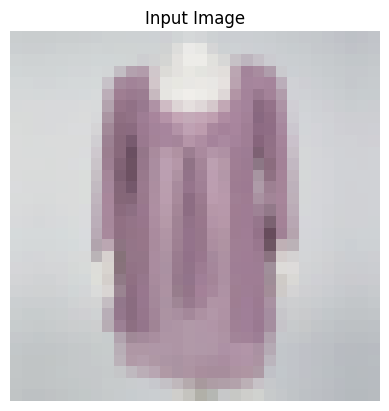

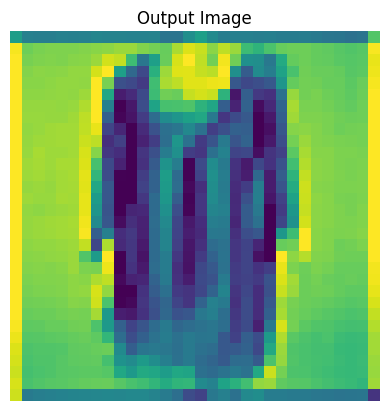

In [47]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from models.compositors.emma_fuse import LayerNorm, AttentionBase, Mlp
from torchvision import transforms
from PIL import Image

# 定义预处理步骤
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整大小为32x32
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 标准化
])

# 加载和预处理图像
image_path = '../image/2.jpg'  # 替换为你的图片路径
input_image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(input_image).unsqueeze(0)  # 转换为批量张量

# 定义卷积层，将3通道RGB图像转换为64通道
class RGBToFeatureMap(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super(RGBToFeatureMap, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv(x)

# 将RGB图像转换为64通道特征图
rgb_to_feature_map = RGBToFeatureMap(in_channels=3, out_channels=64)
feature_tensor = rgb_to_feature_map(input_tensor)

# 实例化GlobalFeatureExtraction模块
dim = 64  # 输入的维度
num_heads = 8  # 注意力头数
module = GlobalFeatureExtraction(dim, num_heads)

# 前向传播
output = module(feature_tensor)

# 反标准化步骤
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# 可视化输入和输出张量
def visualize_tensor(tensor, title=''):
    tensor = tensor.squeeze().detach().cpu()
    if tensor.shape[0] == 3:  # 处理三通道图像
        tensor = inv_normalize(tensor)  # 反标准化
        np_img = tensor.permute(1, 2, 0).numpy()
    else:  # 处理单通道图像
        np_img = tensor.numpy()
        np_img = np_img[0]

    # 将数据裁剪到有效范围内
    np_img = np.clip(np_img, 0, 1)
    
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 可视化输入图像
visualize_tensor(input_tensor[0], title='Input Image')

# 可视化输出图像
visualize_tensor(output[0], title='Output Image')


## 残差块

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from einops import rearrange
import numbers
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, padding_mode="reflect"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, padding_mode="reflect"),
        )

    def forward(self, x):
        out = self.conv(x)
        return out + x

## 局部特征提取模块

In [3]:
class LocalFeatureExtraction(nn.Module):
    def __init__(self, dim=64, num_blocks=2):
        super(LocalFeatureExtraction, self).__init__()
        self.Extraction = nn.Sequential(*[ResBlock(dim, dim) for i in range(num_blocks)])

    def forward(self, x):
        return self.Extraction(x)

In [4]:
import torch
import torch.nn as nn

# 定义输入张量，形状为 (batch_size, channels, height, width)
input_tensor = torch.randn(1, 64, 32, 32)  # 假设输入是一个 32x32 的图像，具有 64 个通道

# 实例化 LocalFeatureExtraction 模块
local_feature_extraction = LocalFeatureExtraction(dim=64, num_blocks=2)

# 前向传播
output_tensor = local_feature_extraction(input_tensor)

print(output_tensor.shape)  # 输出张量的形状


torch.Size([1, 64, 32, 32])


## 提取特征的CNN模块

In [5]:
class Restormer_CNN_block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Restormer_CNN_block, self).__init__()
        self.embed = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=False, padding_mode="reflect")
        self.GlobalFeature = GlobalFeatureExtraction(dim=out_dim, num_heads=8)
        self.LocalFeature = LocalFeatureExtraction(dim=out_dim)
        self.FFN = nn.Conv2d(out_dim * 2, out_dim, kernel_size=3, stride=1, padding=1, bias=False,
                             padding_mode="reflect")

    def forward(self, x):
        x = self.embed(x)
        x1 = self.GlobalFeature(x)
        x2 = self.LocalFeature(x)
        out = self.FFN(torch.cat((x1, x2), 1))
        return out

In [8]:
import torch

# 定义输入张量，形状为 (batch_size, in_dim, height, width)
input_tensor = torch.randn(1, 3, 32, 32)  # 假设输入是一个 32x32 的 RGB 图像

# 实例化 Restormer_CNN_block 模块
restormer_block = Restormer_CNN_block(in_dim=3, out_dim=64)

# 前向传播
output_tensor = restormer_block(input_tensor)

print(output_tensor.shape)  # 输出张量的形状


torch.Size([1, 64, 32, 32])
